In [70]:
import os
import torch
import gpytorch
import torchmetrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data_dir = 'data'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [71]:
df = pd.read_csv(os.path.join(data_dir, 'final_data.csv'))
df['tau_ab_ratio'] = df['TAU_bl'] / df['ABETA_bl']
df['ptau_ab_ratio'] = df['PTAU_bl'] / df['ABETA_bl']
df['A+'] = df['ABETA_bl'].apply(lambda x: 1 if x < 880 else 0)
df['T+'] = df['ptau_ab_ratio'].apply(lambda x: 1 if x > 0.028 else 0)
df['N+'] = df['tau_ab_ratio'].apply(lambda x: 1 if x > 0.33 else 0)
df = df.drop(columns=['PTEDUCAT','TAU_bl','PTAU_bl','ABETA_bl', 'MMSE_bl','EcogPtTotal_bl', 'LDELTOTAL_BL', 'mPACCdigit_bl', 'mPACCtrailsB_bl', 'RAVLT_immediate_bl', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'tau_ab_ratio', 'ptau_ab_ratio'])

In [72]:
class SVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(SVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 1), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return plane_output

    # def compute_kernel(self, x):
    #     return self.kernel(x).evaluate()



# STL

## Predict A+

In [4]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['A+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [47]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.7141
Epoch [2/100], Loss: 1.6757
Epoch [3/100], Loss: 1.6409
Epoch [4/100], Loss: 1.6111
Epoch [5/100], Loss: 1.5844
Epoch [6/100], Loss: 1.5579
Epoch [7/100], Loss: 1.5289
Epoch [8/100], Loss: 1.4971
Epoch [9/100], Loss: 1.4642
Epoch [10/100], Loss: 1.4293
Epoch [11/100], Loss: 1.3905
Epoch [12/100], Loss: 1.3494
Epoch [13/100], Loss: 1.3105
Epoch [14/100], Loss: 1.2726
Epoch [15/100], Loss: 1.2393
Epoch [16/100], Loss: 1.2114
Epoch [17/100], Loss: 1.1875
Epoch [18/100], Loss: 1.1698
Epoch [19/100], Loss: 1.1571
Epoch [20/100], Loss: 1.1449
Epoch [21/100], Loss: 1.1322
Epoch [22/100], Loss: 1.1199
Epoch [23/100], Loss: 1.1053
Epoch [24/100], Loss: 1.0860
Epoch [25/100], Loss: 1.0602
Epoch [26/100], Loss: 1.0282
Epoch [27/100], Loss: 0.9934
Epoch [28/100], Loss: 0.9674
Epoch [29/100], Loss: 0.9457
Epoch [30/100], Loss: 0.9237
Epoch [31/100], Loss: 0.9016
Epoch [32/100], Loss: 0.8829
Epoch [33/100], Loss: 0.8644
Epoch [34/100], Loss: 0.8499
Epoch [35/100], Loss: 0

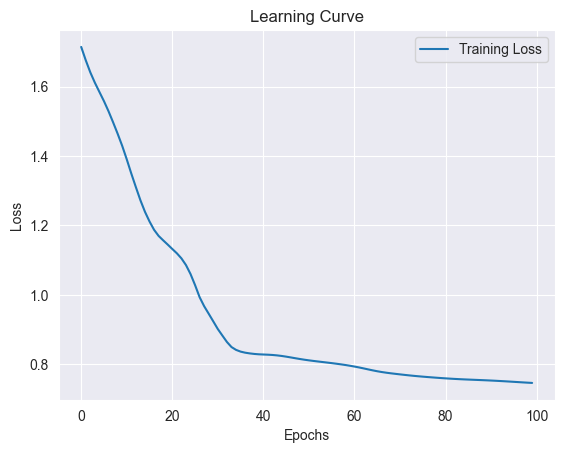

In [48]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [49]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:", 2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.847926267281106
Precision: 0.8983957219251337
Recall: 0.7813953488372093
F1 Score: 0.8358208955223881


In [51]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np, y_test_pred_np)) / (precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np, y_test_pred_np)))

Test Accuracy: 0.8165137614678899
Test Precision: 0.8235294117647058
Test Recall: 0.7924528301886793
Test F1 Score: 0.8076923076923077


# Predict T+

In [57]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['T+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [58]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.2370
Epoch [2/100], Loss: 1.1808
Epoch [3/100], Loss: 1.1260
Epoch [4/100], Loss: 1.0757
Epoch [5/100], Loss: 1.0345
Epoch [6/100], Loss: 1.0041
Epoch [7/100], Loss: 0.9830
Epoch [8/100], Loss: 0.9667
Epoch [9/100], Loss: 0.9519
Epoch [10/100], Loss: 0.9369
Epoch [11/100], Loss: 0.9220
Epoch [12/100], Loss: 0.9076
Epoch [13/100], Loss: 0.8939
Epoch [14/100], Loss: 0.8806
Epoch [15/100], Loss: 0.8670
Epoch [16/100], Loss: 0.8528
Epoch [17/100], Loss: 0.8388
Epoch [18/100], Loss: 0.8262
Epoch [19/100], Loss: 0.8158
Epoch [20/100], Loss: 0.8068
Epoch [21/100], Loss: 0.7987
Epoch [22/100], Loss: 0.7917
Epoch [23/100], Loss: 0.7863
Epoch [24/100], Loss: 0.7820
Epoch [25/100], Loss: 0.7784
Epoch [26/100], Loss: 0.7752
Epoch [27/100], Loss: 0.7723
Epoch [28/100], Loss: 0.7698
Epoch [29/100], Loss: 0.7674
Epoch [30/100], Loss: 0.7653
Epoch [31/100], Loss: 0.7634
Epoch [32/100], Loss: 0.7616
Epoch [33/100], Loss: 0.7599
Epoch [34/100], Loss: 0.7583
Epoch [35/100], Loss: 0

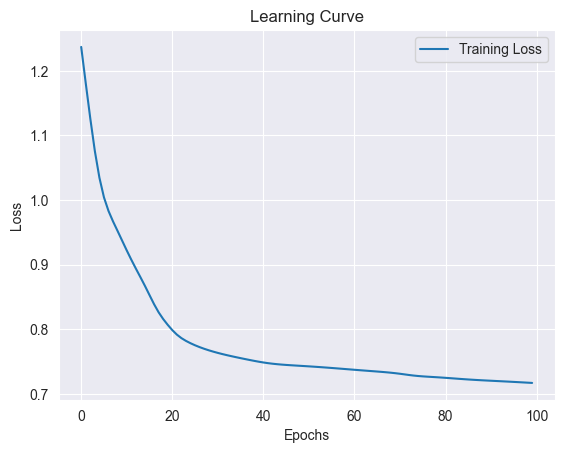

In [59]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [60]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.9009216589861752
Precision: 0.9035532994923858
Recall: 0.8811881188118812
F1 Score: 0.8922305764411027


In [61]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.8990825688073395
Test Precision: 0.9444444444444444
Test Recall: 0.864406779661017
Test F1 Score: 0.9026548672566371


# Predict N+

In [73]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df['N+']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device).unsqueeze(1)

In [74]:
model = SVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 2.1395
Epoch [2/100], Loss: 2.1131
Epoch [3/100], Loss: 2.0839
Epoch [4/100], Loss: 2.0520
Epoch [5/100], Loss: 2.0194
Epoch [6/100], Loss: 1.9866
Epoch [7/100], Loss: 1.9537
Epoch [8/100], Loss: 1.9197
Epoch [9/100], Loss: 1.8846
Epoch [10/100], Loss: 1.8509
Epoch [11/100], Loss: 1.8186
Epoch [12/100], Loss: 1.7853
Epoch [13/100], Loss: 1.7493
Epoch [14/100], Loss: 1.7110
Epoch [15/100], Loss: 1.6710
Epoch [16/100], Loss: 1.6272
Epoch [17/100], Loss: 1.5775
Epoch [18/100], Loss: 1.5239
Epoch [19/100], Loss: 1.4715
Epoch [20/100], Loss: 1.4248
Epoch [21/100], Loss: 1.3778
Epoch [22/100], Loss: 1.3300
Epoch [23/100], Loss: 1.2830
Epoch [24/100], Loss: 1.2315
Epoch [25/100], Loss: 1.1751
Epoch [26/100], Loss: 1.1208
Epoch [27/100], Loss: 1.0741
Epoch [28/100], Loss: 1.0312
Epoch [29/100], Loss: 0.9887
Epoch [30/100], Loss: 0.9612
Epoch [31/100], Loss: 0.9373
Epoch [32/100], Loss: 0.9164
Epoch [33/100], Loss: 0.9001
Epoch [34/100], Loss: 0.8915
Epoch [35/100], Loss: 0

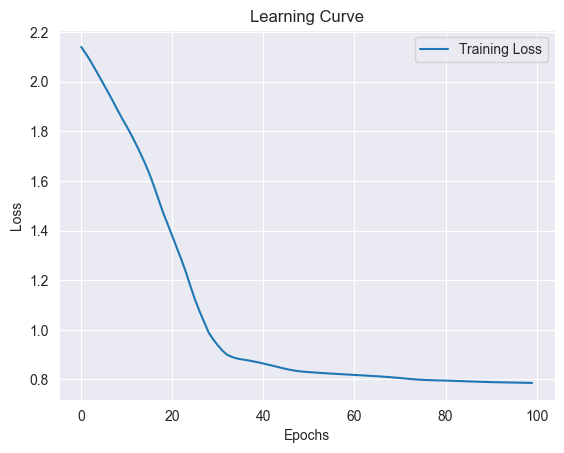

In [75]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [76]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np))
    print("Recall:", recall_score(y_train_np, y_pred_np))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np) * recall_score(y_train_np, y_pred_np)) / (
              precision_score(y_train_np, y_pred_np) + recall_score(y_train_np, y_pred_np)))

Accuracy: 0.8986175115207373
Precision: 0.8640776699029126
Recall: 0.9175257731958762
F1 Score: 0.89


In [77]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np) * recall_score(y_test_np,
                                                                  y_test_pred_np)) / (
              precision_score(y_test_np, y_test_pred_np) + recall_score(y_test_np,
                                                                        y_test_pred_np)))

Test Accuracy: 0.9174311926605505
Test Precision: 0.9433962264150944
Test Recall: 0.8928571428571429
Test F1 Score: 0.9174311926605505


# MTL

In [80]:
class MultitaskSVM(torch.nn.Module):
    def __init__(self, features, targets, kernel: gpytorch.kernels.Kernel):
        super(MultitaskSVM, self).__init__()
        self.features = features
        self.targets = targets
        self.kernel = kernel
        self.w = torch.nn.Parameter(torch.randn(features.shape[1], 3), requires_grad=True)
        self.b = torch.nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        plane_output = x.matmul(self.w) + self.b
        return plane_output

In [83]:
X = df.drop(columns=['A+', 'T+', 'N+'])
y = df.filter(['A+', 'T+', 'N+'])

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=40)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

In [84]:
model = MultitaskSVM(X_train, y_train, kernel=gpytorch.kernels.RBFKernel()).to(device)

bhl = torchmetrics.classification.BinaryHingeLoss(squared=True).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-4)

train_losses = []

epochs = 100
for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = bhl(output, y_train)
    loss.backward()
    train_losses.append(loss.item())
    optimizer.step()
    print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/100], Loss: 1.6443
Epoch [2/100], Loss: 1.5958
Epoch [3/100], Loss: 1.5485
Epoch [4/100], Loss: 1.4996
Epoch [5/100], Loss: 1.4489
Epoch [6/100], Loss: 1.3991
Epoch [7/100], Loss: 1.3519
Epoch [8/100], Loss: 1.3086
Epoch [9/100], Loss: 1.2692
Epoch [10/100], Loss: 1.2328
Epoch [11/100], Loss: 1.1983
Epoch [12/100], Loss: 1.1661
Epoch [13/100], Loss: 1.1379
Epoch [14/100], Loss: 1.1142
Epoch [15/100], Loss: 1.0932
Epoch [16/100], Loss: 1.0735
Epoch [17/100], Loss: 1.0546
Epoch [18/100], Loss: 1.0372
Epoch [19/100], Loss: 1.0216
Epoch [20/100], Loss: 1.0076
Epoch [21/100], Loss: 0.9947
Epoch [22/100], Loss: 0.9827
Epoch [23/100], Loss: 0.9712
Epoch [24/100], Loss: 0.9601
Epoch [25/100], Loss: 0.9494
Epoch [26/100], Loss: 0.9392
Epoch [27/100], Loss: 0.9297
Epoch [28/100], Loss: 0.9212
Epoch [29/100], Loss: 0.9136
Epoch [30/100], Loss: 0.9069
Epoch [31/100], Loss: 0.9009
Epoch [32/100], Loss: 0.8956
Epoch [33/100], Loss: 0.8907
Epoch [34/100], Loss: 0.8864
Epoch [35/100], Loss: 0

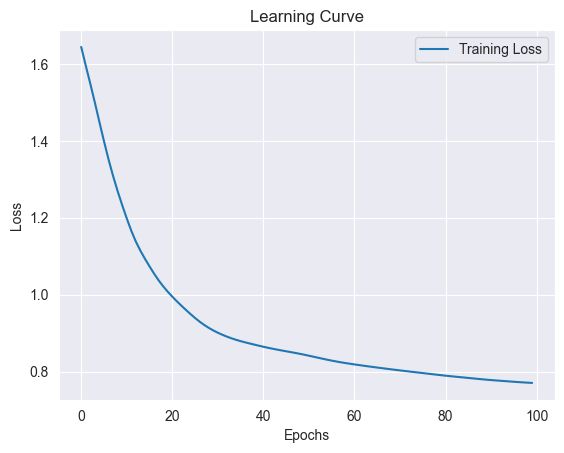

In [85]:
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [87]:
model.eval()
with torch.no_grad():
    y_pred = model(X_train)
    y_pred = (y_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_pred_np = y_pred.cpu().numpy()
    y_train_np = y_train.cpu().numpy()
    # For multitask (MTL) evaluation
    print("Accuracy:", accuracy_score(y_train_np, y_pred_np))
    print("Precision:", precision_score(y_train_np, y_pred_np, average='macro'))
    print("Recall:", recall_score(y_train_np, y_pred_np, average='macro'))
    print("F1 Score:",
          2 * (precision_score(y_train_np, y_pred_np, average='macro') * recall_score(y_train_np, y_pred_np, average='macro')) /
          (precision_score(y_train_np, y_pred_np, average='macro') + recall_score(y_train_np, y_pred_np, average='macro')))


Accuracy: 0.7511520737327189
Precision: 0.8736786506454752
Recall: 0.8726027505651549
F1 Score: 0.8731403691693328


In [88]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_test_pred = (y_test_pred > 0.5).float()  # Convert probabilities to binary predictions
    y_test_pred_np = y_test_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    print("Test Accuracy:", accuracy_score(y_test_np, y_test_pred_np))
    print("Test Precision:", precision_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test Recall:", recall_score(y_test_np, y_test_pred_np, average='macro'))
    print("Test F1 Score:", 2 * (
        precision_score(y_test_np, y_test_pred_np, average='macro') * recall_score(y_test_np,
                                                                  y_test_pred_np, average='macro')) / (
              precision_score(y_test_np, y_test_pred_np, average='macro') + recall_score(y_test_np,
                                                                        y_test_pred_np, average='macro')))

Test Accuracy: 0.7247706422018348
Test Precision: 0.9086123680241327
Test Recall: 0.8267013873026025
Test F1 Score: 0.8657236800666311
